# Programming Assignment 5
**Pooya Kabiri - 96521434**

Importing prerequisites

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Plotting cell

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

# Detecting orthogonal edges

Implementing some helper functions:

**`create_kernels()`** : This method generates two kernels used by other functions.

The kernels used are actually **Sobel operators rotated 45 degrees**, So they can detect orthogonal edges.

In [3]:
def create_kernels():
    kernel_45 = np.array([[2, 1, 0], [1, 0, -1], [0, -1, -2]])
    kernel_135 = np.rot90(kernel_45)

    return kernel_45, kernel_135

Implementing functions for applying above kernels on image using OpenCV Filter2D method (convolution).

In [4]:
def get_45_edges(image):
    '''
    Returns the image which shows the 45-degree edges.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        edges_45 (numpy.ndarray): The 45-degree edges of input image.
    '''
    kernel, _ = create_kernels()
    
    print('45/225 degree detector:\n', kernel)
    
    edges_45 = cv2.filter2D(image, -1, kernel)

    return edges_45

def get_135_edges(image):
    '''
    Returns the image which shows the 135-degree edges.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        edges_135 (numpy.ndarray): The 135-degree edges of input image.
    '''
    _ , kernel = create_kernels()
    
    print('135/315 degree detector:\n', kernel)
    
    edges_135 = cv2.filter2D(image, -1, kernel)
    
    return edges_135

Test your implementation (dont change this cell)

45/225 degree detector:
 [[ 2  1  0]
 [ 1  0 -1]
 [ 0 -1 -2]]
135/315 degree detector:
 [[ 0 -1 -2]
 [ 1  0 -1]
 [ 2  1  0]]


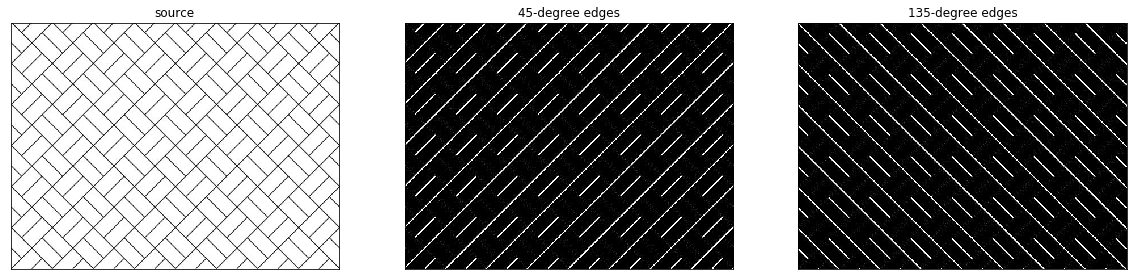

In [5]:
image_list = []

image = cv2.imread(os.path.join('images', '1.jpg'), cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'source', 'img'])

edges_45 = get_45_edges(image)
edges_135 =get_135_edges(image)

image_list.append([edges_45, '45-degree edges', 'img'])
image_list.append([edges_135, '135-degree edges', 'img'])

plotter(image_list, 1, 3, True, 20, 10, 'Q4')

# Canny Edge Detector

**`gaussian(x, y, std)`**: This method computes Gaussian function for a pair of (x, y) coordinates and the corresponding Standard Deviation.

In [6]:
def gaussian(x, y, std):
    return (1 / (2 * np.pi * np.square(std))) * (np.exp(-(np.square(x) + np.square(y)) / (2 * np.square(std))))

## Canny Edge Detector
The Canny edge detection algorithm is composed of 4 steps:
1. Smooth image with Gaussian Filter.
2. Find magnitude and orientation of gradient.
3. Apply Non-max suppression.
4. Apply Hysteresis threshold.

### Step 1: Smooth image with Guassian Filter.
Since we will use derivatives calculation in the next step and gradients are highly sensitive to noise, the image must be first smoothed using a Gaussian kernel. The equation for a Gaussian kernel is:
\begin{equation*}
G = 
\frac{1}{2 \pi\sigma ^ 2}e^{-\frac{x^2 + y^2}{2\sigma^2}}
\end{equation*}

**`gaussian_kernel(size, sigma)`**: This method computes a square Gaussian kernel. Gets size and Standard Deviation (Sigma) as arguments. 

In [7]:
def gaussian_kernel(size, sigma=1):
    '''
    Calculates and Returns Gaussian kernel.

    Parameters:
        size (int): size of kernel.
        sigma(float): standard deviation of gaussian kernel

    Returns:
        gaussian: A 2d array shows gaussian kernel
    '''
    kernel = np.zeros((size,size), np.float)
    
    zero_based_gap = np.floor(size / 2)
    
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            x = i - zero_based_gap
            y = j - zero_based_gap
            kernel[i, j] = gaussian(x, y, sigma)
            
    return kernel

### Step 2: Find magnitude and orientation of gradient.

The gradient calculation of the image detects the edge magnitude and orientation. So use Sobel kernel in both direction x and y. $K_x$ and $K_y$ are horizontal and vertical Sobel kernels respectively.

$$k_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix} ,
k_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$

Then we convolve kernels with the image and find the magnitude and orientation of the smooth image.

\begin{equation*}
magnitude = 
\sqrt{I_x^2 + I_y^2}
\end{equation*}

\begin{equation*}
theta(x,y) = arctan(\frac{I_y}{I_x})
\end{equation*}

**`sobel_filters(image)`**: This method creates vertical and horizontal Sobel Operators and convolves them on the input image using OpenCV Filter2D convolution method. Returns the magnitude and direction (in degrees, 0 - 360) of the derivations.

In [8]:
def sobel_filters(image):
    '''
    finds the magnitude and orientation of the image using Sobel kernels.

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        (magnitude, theta): A tuple consists of magnitude and orientation of the image gradients.
    '''
    
    Kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    Ky = Kx.T

    Ix = cv2.filter2D(image, -1, Kx)
    Iy = cv2.filter2D(image, -1, Ky)
    
    magnitude = np.sqrt(np.square(Ix) + np.square(Iy))
    magnitude *= 255.0 / magnitude.max()
    
    arctan = np.arctan2(Iy, Ix)
    theta = np.array([(np.rad2deg(x) + 360) if x < 0 else np.rad2deg(x) for x in arctan.flatten()]).reshape((image.shape))


    return (magnitude, theta)

### Step 3: Non-Maximum Suppression

Ideally, the final image should have thin edges. Thus, we must perform non-maximum suppression to thin the edges. The principle is simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions.

**`non_max_suppression(magnitude, theta)`**: This method performs NMS on the magnitude input using theta which is the matrix of derivative directions. 

In [9]:
def non_max_suppression(magnitude, theta): 
    '''
    Applies Non-Maximum Suppression.

    Parameters:
        image (numpy.ndarray): The input image.
        theta (numpy.ndarray): The orientation of the image gradients.

    Returns:
        Z(numpy.ndarray): Output of Non-Maximum Suppression algorithm.
    '''
    PI = 180
    
    M, N = image.shape
    Z = np.zeros((M,N), dtype=np.int32)
    
    
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            
            orientation = theta[i, j]

            if (0 <= orientation < PI / 8) or (15 * PI / 8 <= orientation <= 2 * PI) or (7 * PI / 8 <= orientation < 9 * PI / 8):
                
                previous_pixel = magnitude[i, j - 1]
                next_pixel = magnitude[i, j + 1]
 
            elif (PI / 8 <= orientation < 3 * PI / 8) or (9 * PI / 8 <= orientation < 11 * PI / 8):
        
                previous_pixel = magnitude[i + 1, j - 1]
                next_pixel = magnitude[i - 1, j + 1]

            elif (3 * PI / 8 <= orientation < 5 * PI / 8) or (11 * PI / 8 <= orientation < 13 * PI / 8):
                
                previous_pixel = magnitude[i - 1, j]
                next_pixel = magnitude[i + 1, j]
            
            elif (5 * PI / 8 <= orientation < 7 * PI / 8) or (13 * PI / 8 <= orientation < 15 * PI / 8):
                
                previous_pixel = magnitude[i - 1, j - 1]
                next_pixel = magnitude[i + 1, j + 1]
                                
            if magnitude[i, j] > previous_pixel and magnitude[i, j] > next_pixel:
                Z[i, j] = magnitude[i, j]
    return Z

### Step 4: Apply Hysteresis threshold.

To find strong, weak, and non-relevant pixels, we use a double threshold. A high threshold is used to identify the strong pixels and a low threshold is used to identify the non-relevant pixels. All pixels having intensity between both thresholds are flagged as weak and the Hysteresis mechanism will help you identify the ones that could be considered as strong and the ones that are considered as non-relevant.

Based on the threshold results, the hysteresis transform weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one.

**`double_threshold(image, lowThreshold, highThreshold)`**: This method performs the double threshold action on input image which is the magnitude of derivation.

In [10]:
def double_threshold(image, lowThreshold, highThreshold):
    '''
    Finds strong, weak, and non-relevant pixels.

    Parameters:
        image (numpy.ndarray): The input image.
        lowThreshold(int): Low Threshold.
        highThreshold(int): High Threshold.
        
    Returns:
        result(numpy.ndarray): Output of applying hysteresis threshold.
    '''
    M, N = image.shape
    
    strong = 255
    weak = 40
    
    image[np.where(image <= lowThreshold)] = 0
    image[np.where((image < highThreshold) & (image > lowThreshold))] = weak
    image[np.where(image >= highThreshold)] = strong
    
    return image

**`hysteresis(image)`**: This method performs hystresis method on the input image in 4 directions : **Top to Bottom, Bottom to Top, Left to Right and Right to Left.**

In [11]:
def hysteresis(image):
    '''
    Finds strong, weak, and non-relevant pixels.

    Parameters:
        image (numpy.ndarray): The input image.
    Returns:
        result(numpy.ndarray): Output of applying hysteresis threshold.
    '''
    
    M, N = image.shape
    result = np.zeros((M,N), dtype=np.int32)
    
    weak = 40
    strong = 255
    
    # top to down
    top_down = image.copy()
    for i in range(M):
        for j in range(N):
            if top_down[i, j] == weak:
                neighbors = top_down[i - 1:i + 1, j - 1:j + 1].flatten()
                if strong in neighbors:
                    top_down[i, j] = strong
                else: 
                    top_down[i, j] = 0
                    
    # bottom to up
    bottom_up = image.copy()
    for i in range(M - 1, 0, -1):
        for j in range(N - 1, 0, -1):
            if bottom_up[i, j] == weak:
                neighbors = bottom_up[i - 1:i + 1, j - 1:j + 1].flatten()
                if strong in neighbors:
                    bottom_up[i, j] = strong
                else: 
                    bottom_up[i, j] = 0
    
    # left to right
    left_to_right = image.copy()
    for i in range(M - 1, 0, -1):
        for j in range(N):
            if left_to_right[i, j] == weak:
                neighbors = left_to_right[i - 1:i + 1, j - 1:j + 1].flatten()
                if strong in neighbors:
                    left_to_right[i, j] = strong
                else: 
                    left_to_right[i, j] = 0
                
    #right to left
    right_to_left = image.copy()
    for i in range(M):
        for j in range(N - 1, 0, -1):
            if right_to_left[i, j] == weak:
                neighbors = right_to_left[i - 1:i + 1, j - 1:j + 1].flatten()
                if strong in neighbors:
                    right_to_left[i, j] = strong
                else: 
                    right_to_left[i, j] = 0
                    
    result = top_down + bottom_up + left_to_right + right_to_left
    result[result > 255] = 255
    
    return result

**`canny(image, kernel_size, sigma, lowtreshold, hightreshold)`**: This method uses all the above methods to perform the whole Canny edge detection.

In [12]:
def canny(image, kernel_size = 5, sigma = 3.5, lowtreshold = 30, hightreshold = 180):
    '''
    Applys Canny edge detector on the input image.

    Parameters:
        image (numpy.ndarray): The input image.
        size (int): size of kernel.
        sigma(float): standard deviation of gaussian kernel.
        lowThreshold(int): Low Threshold.
        highThreshold(int): High Threshold.
        
    Returns:
        img_smoothed(numpy.ndarray): Result of applying the Gaussian kernel on the input image.
        gradient(numpy.ndarray): The image of the gradients.
        nonMaxImg(numpy.ndarray): Output of Non-Maximum Suppression algorithm.
        thresholdImg(numpy.ndarray): Output of applying hysteresis threshold.
        img_final(numpy.ndarray): Result of canny edge detector. The image of detected edges.
    '''
    img_smoothed = cv2.filter2D(image, -1, gaussian_kernel(kernel_size, sigma))
    magnitude, theta = sobel_filters(img_smoothed)
    
    nonMaxImg = non_max_suppression(magnitude, theta)
    thresholdImg = double_threshold(nonMaxImg, lowtreshold, hightreshold)
    img_final = hysteresis(thresholdImg)
    
    return img_smoothed, magnitude, nonMaxImg, thresholdImg, img_final

Test your implementation (dont change this cell)

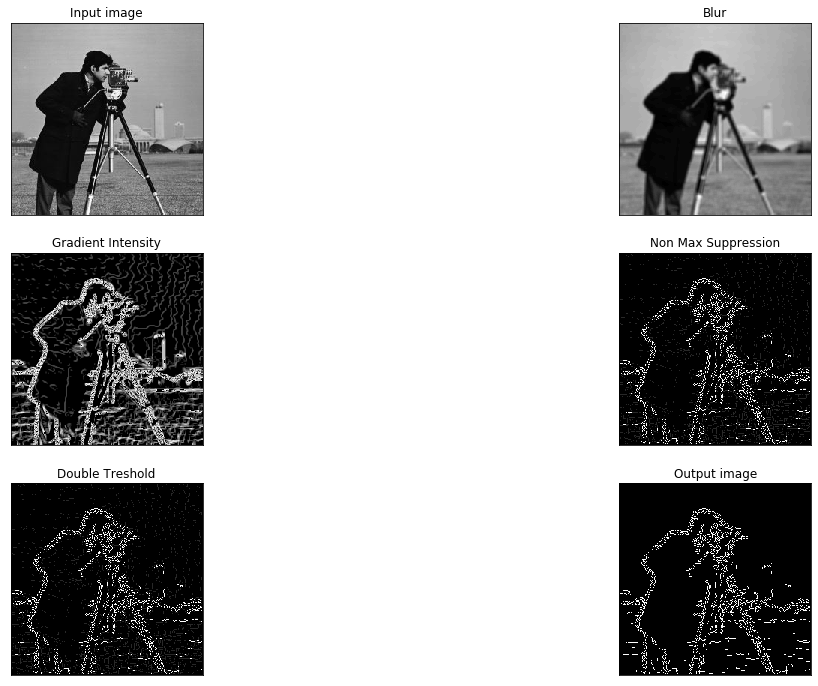

In [13]:
image_list = []
image = cv2.imread(os.path.join('images', '2.jpg'), cv2.IMREAD_GRAYSCALE)
img_smoothed, gradient, nonMaxImg, thresholdImg, img_final = canny(image)

image_list.append([image, 'Input image', 'img'])
image_list.append([img_smoothed, 'Blur', 'img'])
image_list.append([gradient.astype(int),'Gradient Intensity', 'img'])
image_list.append([nonMaxImg, 'Non Max Suppression', 'img'])
image_list.append([thresholdImg, 'Double Treshold', 'img'])
image_list.append([img_final, 'Output image', 'img'])

plotter(image_list, 3, 2, True, 20, 12, 'Q5')